In [1]:
!pip install xgboost

In [2]:
# bringing in the packages I need for data and models
import pandas as pd  # for handling the excel data
import numpy as np  # for numbers and math
from datetime import datetime  # for dates
import re  # for pulling numbers from text
from sklearn.impute import SimpleImputer  # to fill missing values
from sklearn.preprocessing import StandardScaler  # to scale data
from sklearn.model_selection import train_test_split  # to split train/test
from xgboost import XGBClassifier  # the model
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix  # to check how good it is
import shap  # for explaining the model
import matplotlib.pyplot as plt  # for plots
import seaborn as sns  # for nicer plots

print("All imports worked okay")  # just to check

All imports worked okay


In [3]:
# load the excel file I uploaded
df = pd.read_excel('df.xlsx', sheet_name='Sheet1')

# check first few rows
print(df.head())

# basic stats
print(df.describe())

# data types and missing
print(df.info())
print(df.isna().sum())

# how many of each diagnosis
print(df["Pathological Diagnosis"].value_counts())

   Unnamed: 0  Patients' Name     AGE PSA_Value_1  PSA_Date_1 PSA_Value_2  \
0           0    ADIE Dominic  67 YRS    9.1ng/ml  2015-10-03   3.00ng/ml   
1           1     EJEMBI John  70 YRS   28.7NG/ML  2012-06-25  26.20ng/ml   
2           2     DAUDA Peter  62 YRS    0.5NG/ML  2011-07-28   5.10ng/ml   
3           3  WUYEP Shedrach  65 YRS   13.9NG/ML  2020-08-03   8.90ng/ml   
4           4    KPAJI Monday  84 YRS  100.0NG/ML  2018-11-20  21.10ng/ml   

   PSA_Date_2 Imaging_Type Imaging_Date      Imaging_Findings  \
0  2015-01-05           US    23/1/2018      enlarged, 181mls   
1  2012-08-07           US   2014-02-02              91.37MLS   
2  2010-06-16           US    26/9/2011                 49MLS   
3  2019-08-08          USS   2022-01-23              ENLARGED   
4  2020-02-19          USS   2019-11-11  enlarged,vol287.8mls   

     Comorbidities                             Pathological Diagnosis  
0  solitary kidney                      ADENOCARCINOMA (GLEASON 7/10)  
1 

In [4]:
# drop duplicate patients by name
df = df.drop_duplicates(subset=["Patients' Name"])

# clean age, pull out the number
df['AGE'] = df['AGE'].str.extract(r'(\d+)', expand=False).astype(float)

# function to clean psa values, remove units and junk
def clean_psa(value):
    if pd.isna(value):
        return np.nan
    value = str(value).lower().replace('ng/ml', '').replace('ng/mls', '').replace('>', '').strip()
    try:
        return float(value)
    except:
        return np.nan

df['PSA_Value_1'] = df['PSA_Value_1'].apply(clean_psa)
df['PSA_Value_2'] = df['PSA_Value_2'].apply(clean_psa)

# cap psa at 100 for outliers
df['PSA_Value_1'] = np.clip(df['PSA_Value_1'], None, 100)
df['PSA_Value_2'] = np.clip(df['PSA_Value_2'], None, 100)

# turn dates into real dates
df['PSA_Date_1'] = pd.to_datetime(df['PSA_Date_1'], errors='coerce')
df['PSA_Date_2'] = pd.to_datetime(df['PSA_Date_2'], errors='coerce')

# drop rows with bad dates or psa
df = df.dropna(subset=['PSA_Date_1', 'PSA_Date_2', 'PSA_Value_1', 'PSA_Value_2'])
df = df[df['PSA_Date_2'] > df['PSA_Date_1']]  # make sure date2 is after date1

print("Rows left after clean:", len(df))
print(df.info())  # check again

Rows left after clean: 153
<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 1 to 343
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Unnamed: 0              153 non-null    int64         
 1   Patients' Name          153 non-null    object        
 2   AGE                     150 non-null    float64       
 3   PSA_Value_1             153 non-null    float64       
 4   PSA_Date_1              153 non-null    datetime64[ns]
 5   PSA_Value_2             153 non-null    float64       
 6   PSA_Date_2              153 non-null    datetime64[ns]
 7   Imaging_Type            153 non-null    object        
 8   Imaging_Date            152 non-null    object        
 9   Imaging_Findings        153 non-null    object        
 10  Comorbidities           150 non-null    object        
 11  Pathological Diagnosis  153 non-null    object        
dtypes: datetime64[ns](2), float6

In [5]:
# time difference in years
df['Time_Diff_Years'] = (df['PSA_Date_2'] - df['PSA_Date_1']).dt.days / 365.25

# psa velocity
df['PSA_Velocity'] = (df['PSA_Value_2'] - df['PSA_Value_1']) / df['Time_Diff_Years']

# psa doubling time, only if velocity positive
df['PSA_Doubling_Time'] = np.where(df['PSA_Velocity'] > 0, 0.693 / (df['PSA_Velocity'] / df['PSA_Value_1']), np.nan)

# pull volume from imaging text
def extract_volume(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'(\d+\.?\d*)\s?(mls|ml|cm3|cm2|cm³|MLS|vol|volume)', str(text), re.I)
    return float(match.group(1)) if match else np.nan

df['Prostate_Volume'] = df['Imaging_Findings'].apply(extract_volume)

# flag if imaging looks suspicious
df['Imaging_Suspicious'] = df['Imaging_Findings'].str.contains('enlarged|lesion|nodule|hypoechoic|remarkable|enlarge', case=False, na=False).astype(int)

# flags for comorbidities
df['HTN'] = df['Comorbidities'].str.contains('HTN|HHDx', case=False, na=False).astype(int)
df['T2DM'] = df['Comorbidities'].str.contains('T2DM|DM|diabetes', case=False, na=False).astype(int)

# make cancer target, 1 if bad, 0 else
def is_cancer(diag):
    diag = str(diag).upper()
    if 'ADENOCARCINOMA' in diag or 'CARCINOMA' in diag or 'MALIGN' in diag:
        return 1
    else:
        return 0

df['Cancer'] = df['Pathological Diagnosis'].apply(is_cancer)

# fill missing numbers with averages
imputer = SimpleImputer(strategy='mean')
numerical_cols = ['AGE', 'PSA_Value_1', 'PSA_Value_2', 'PSA_Velocity', 'PSA_Doubling_Time', 'Prostate_Volume']
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

print(df['Cancer'].value_counts())  # see balance

Cancer
1    82
0    71
Name: count, dtype: int64


In [6]:
# features list
features = numerical_cols + ['Imaging_Suspicious', 'HTN', 'T2DM']
X = df[features]
y = df['Cancer']

# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# weight for imbalance
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos if pos > 0 else 1
print("Weight for positive class:", scale_pos_weight)

Weight for positive class: 0.8769230769230769


In [7]:
# set up model with weight
model = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=50, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# predict on test
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# print results
print(classification_report(y_test, y_pred))
print('AUC score:', roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))

# simple baseline check
baseline_pred = (df.loc[y_test.index, 'PSA_Value_1'] > 4).astype(int)
print('Baseline AUC:', roc_auc_score(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.67      0.86      0.75        14
           1       0.85      0.65      0.73        17

    accuracy                           0.74        31
   macro avg       0.76      0.75      0.74        31
weighted avg       0.77      0.74      0.74        31

AUC score: 0.8067226890756303
[[12  2]
 [ 6 11]]
Baseline AUC: 0.5126050420168068


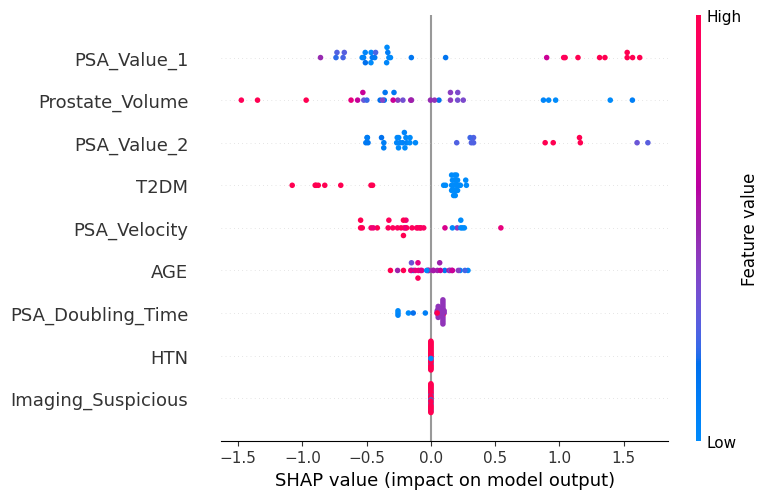

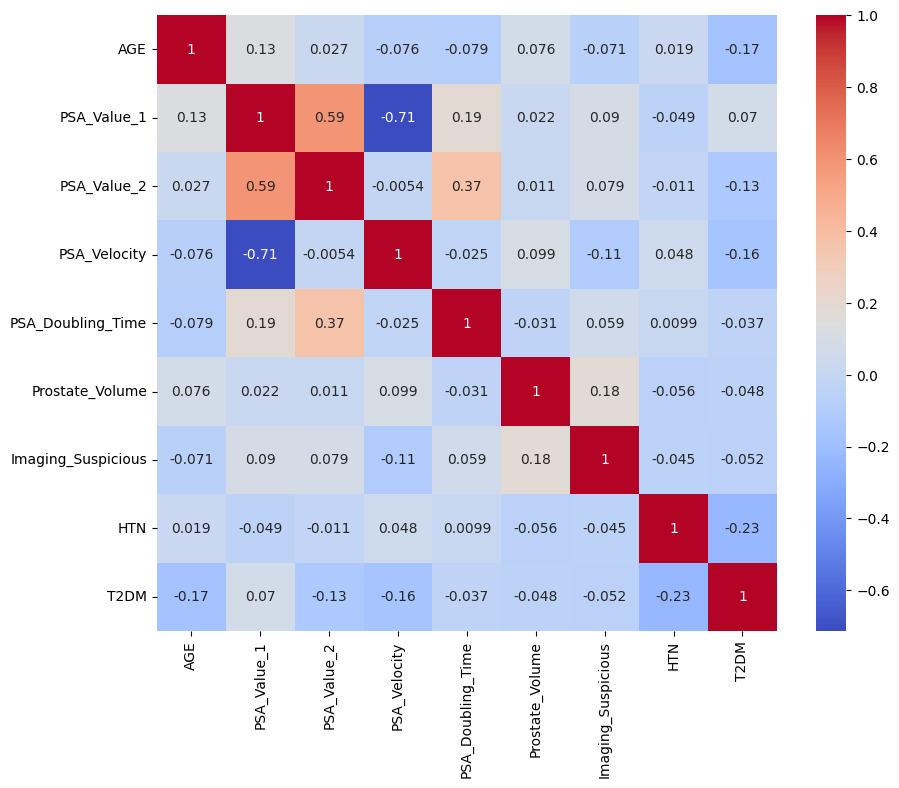

In [8]:
# explain with shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.savefig('shap_plot.png')
plt.show()

# correlation plot
plt.figure(figsize=(10,8))
sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
plt.savefig('corr_plot.png')
plt.show()